# Example tracking workflow
## Comments
- Mention that throughout:
    - "coords" will be the full table of coordinates, along with assigned track IDs
    - "tracks" will be the coordinates of the most recent track instance
    - "points" will be the coordinates for the current frame

## Ideas
- Cover both Munkres (dense cost matrix) and JV LAPMOD (sparse cost matrix) for linking, comparing speed and memory allocation for different number of points.  This may be one for the talk, rather than having others do it.  That way it doesn't matter what memory is available.
- Start by getting a basic (adjacent frames only, no track splitting/merging) workflow completed.  For the previous frames, set start_frame and end_frame to the same value (i.e. frame-1).
- Add more factors to cost matrix.  The easiest to show may be conservation of size.  Mention that we could also add a threshold for size change, but we won't.  Example data will need to have instances of miss-linking that are resolved with size-based linking.
- Add multi-frame tracking by extending linking to n previous frames.  This will require addition of extraction of only the most recent instances of each track.
- Switch to using a Kalman filter to predict the location of each active track in the current frame, then calculate costs based on the distance of each point to this predicted location.  When describing the Kalman Filter, maybe use the pair of images from the section "THE KALMAN GAIN INTUITION" on the page https://www.kalmanfilter.net/kalman1d.html.


## Installing packages

In [3]:
!pip install --user matplotlib
!pip install --user pandas
!pip install --user Pillow
!pip install --user scikit-image
!pip install --user opencv-python

## Importing libraries

In [1]:
import math
import sys
import time
import util

import numpy as np

from scipy.optimize import linear_sum_assignment

## Getting coordinates present in frame

In [2]:
def get_current_coords(coords, frame):
    # Identifying rows of "coords" with current frame number
    rows = coords.index[coords.FRAME == frame]

    return rows

## Get available tracks

In [3]:
def get_available_tracks(coords, start_frame, end_frame):
    # Getting all rows present within the specified time interval
    rows = coords.index[(coords.FRAME >= start_frame) & (coords.FRAME <= end_frame)]
    
    # Getting the most recent instance of this track
    track_rows = []
    unique_IDs = np.unique(coords.TRACK_ID[rows])
    for unique_ID in unique_IDs:
        if unique_ID != 0:
            # Getting rows for all instances of this track
            instances = coords.index[coords.TRACK_ID == unique_ID]    
            
            # Getting most recent instance of this track and appending it to final_rows
            track_rows.append(instances[-1:][0])
                    
    return track_rows

## Assigning track IDs to unlinked points

In [4]:
def assign_new_IDs(coords, point_rows):
    # Getting the maximum track ID present in coords
    max_ID = coords.TRACK_ID.max()
    
    # Iterating over all current points and assigning the next available ID if they're still 0
    for point_row in point_rows:
        if coords.TRACK_ID[point_row] == 0:
            max_ID = max_ID + 1
            coords.TRACK_ID.at[point_row] = max_ID

## Predict track location

In [5]:
def get_predicted_location(coords, track_ID):
    # Extract the x,y,t coordinates for the current track
    
    # Use the Kalman filter to predict the location of this track
    
    return 0

## Calculate linking costs

In [6]:
def calculate_dense_cost_matrix(coords,track_rows,point_rows,thresh):
    # Creating the empty array
    costs = np.empty((len(track_rows),len(point_rows)))
        
    # Iterating over each pair, calculating the cost
    for track_i, track_row in enumerate(track_rows):
        for point_i,point_row in enumerate(point_rows):            
            cost = calculate_cost(coords,track_row,point_row,thresh)
            costs[track_i,point_i] = cost
           
    return costs
    
def calculate_cost(coords,track_row,point_row,thresh):
    # Spatial linking (distance between two points)
    dx = coords.X[point_row] - coords.X[track_row]
    dy = coords.Y[point_row] - coords.Y[track_row]
    d = math.sqrt(dx*dx + dy*dy)
    
    # If the two points are separated by more than the linking threshold, set them to infinity ('inf')
    if d > thresh:
        d = 1000000000
    
    return d

def calculate_cost_with_size(coords,track_row,point_row,thresh):
    # Spatial linking (distance between two points)
    dx = coords.X[point_row] - coords.X[track_row]
    dy = coords.Y[point_row] - coords.Y[track_row]
    d = math.sqrt(dx*dx + dy*dy)
    
    # ADD SIZE COST
    
    # If the two points are separated by more than the linking threshold, set them to infinity ('inf')
    if d > thresh:
        d = 1000000000
    
    return d

## Inheriting track IDs from previous frame
If the linked point in the previous frame already has an ID assigned to it, pass this on to the linked point (this SHOULD always be the case).  If our point wasn't assigned a link, set its track ID to the smallest unused value.

In [8]:
def assign_IDs(costs, assignments, coords, track_rows, point_rows):
    for track_assignment, point_assignment in zip(assignments[0],assignments[1]):
        # Even though we set disallowed costs to 1000000000, if there are no better options, Munkres will still 
        # assign these. We need to check if the assignment corresponds to one of these disallowed assignments.
        if costs[track_assignment,point_assignment] < 1000000000:
            ID = coords.TRACK_ID[track_rows[track_assignment]]
            coords.TRACK_ID.at[point_rows[point_assignment]] = ID


## Calculating track statistics
This should eventually return an array with each statistic listed for each track
- Total path length
- Euclidean distance
- Directionality
- Mean track speed
- MSD
- Angular statistics
    - Average direction

In [8]:
def calculate_track_statistics(coords):
    # Getting unique track IDs
    unique_IDs = np.unique(coords.TRACK_ID)
    
    for unique_ID in unique_IDs:
        print("TRACK %i" % unique_ID)
        # Getting row indices for this track
        track_rows = coords.index[coords.TRACK_ID == unique_ID]
        
        total_path_length = calculate_total_path_length(coords,track_rows)
        path_euclidean_distance = calculate_path_euclidean_distance(coords,track_rows)
        directionality_ratio = calculate_directionality_ratio(total_path_length,path_euclidean_distance)
        mean_track_orientation = calculate_mean_track_orientation(coords,track_rows)
    
        print("    Total path length = %f px" % total_path_length)
        print("    Path Euclidean distance = %f px" % path_euclidean_distance)
        print("    Path directionality ratio = %f " % directionality_ratio)
        print("    Mean track orientation = %f degs" % mean_track_orientation)
    
        
def calculate_total_path_length(coords,track_rows):
    path_length = 0
    
    for i in range(1,len(track_rows)):
        x1 = coords.X[track_rows[i-1]]
        x2 = coords.X[track_rows[i]]
        y1 = coords.Y[track_rows[i-1]]
        y2 = coords.Y[track_rows[i]]
        
        dx = x2-x1
        dy = y2-y1
        
        distance = math.sqrt(dx*dx+dy*dy)
        
        path_length = path_length + distance
    
    return path_length

def calculate_path_euclidean_distance(coords,track_rows):
    # Getting coordinates for first and last points
    x1 = coords.X[track_rows[0]]
    x2 = coords.X[track_rows[-1]]
    y1 = coords.Y[track_rows[0]]
    y2 = coords.Y[track_rows[-1]]
    
    dx = x2-x1
    dy = y2-y1
        
    # Returning the end-to-end distance
    return math.sqrt(dx*dx+dy*dy)

def calculate_directionality_ratio(total_path_length,euclidean_distance):
    # If the total path length is 0 we will get a divide by 0 error.  As such, we return a NaN (not a number) value
    if total_path_length == 0:
        return np.nan
    
    return euclidean_distance/total_path_length

def calculate_mean_track_orientation(coords,track_rows):
    # Getting total x and y vector magnitudes
    x_sum = 0
    y_sum = 0
    
    for i in range(1,len(track_rows)):
        x1 = coords.X[track_rows[i-1]]
        x2 = coords.X[track_rows[i]]
        y1 = coords.Y[track_rows[i-1]]
        y2 = coords.Y[track_rows[i]]
        
        x_sum = x_sum + (x2-x1)
        y_sum = y_sum + (y2-y1)
    
    # Calculating the average x and y vectors
    n = len(track_rows)
    x_vec = x_sum/n
    y_vec = y_sum/n
    
    print("        x = %f " % x_vec)
    print("        y = %f " % y_vec)
    
    # Returning the orientation of these final vectors
    if x_vec == 0:
        if y_vec > 0:
            return 90
        elif y_vec == 0:
            return np.nan
        elif y_vec < 0:
            return -90
    
    return math.degrees(math.atan2(y_vec,x_vec))
    

## Main workflow

In [10]:
# Testing track measurements
path = "../data/TrackedCoordinatesNoHeader.csv"
coords = util.load_coordinates(path);

calculate_track_statistics(coords)


Loading coordinates from " ../data/TrackedCoordinatesNoHeader.csv "
Loaded data shape:  (8639, 5)
 
TRACK 1
        x = 0.278725 
        y = 0.046223 
    Total path length = 109.139171 px
    Path Euclidean distance = 8.758488 px
    Path directionality ratio = 0.080251 
    Mean track orientation = 9.416155 degs
TRACK 8
        x = -0.540984 
        y = 0.016393 
    Total path length = 182.382276 px
    Path Euclidean distance = 33.015148 px
    Path directionality ratio = 0.181022 
    Mean track orientation = 178.264295 degs
TRACK 9
        x = 0.556918 
        y = -1.159320 
    Total path length = 184.600897 px
    Path Euclidean distance = 78.455142 px
    Path directionality ratio = 0.424999 
    Mean track orientation = -64.341130 degs
TRACK 10
        x = -0.510791 
        y = -2.679137 
    Total path length = 14.237567 px
    Path Euclidean distance = 13.636973 px
    Path directionality ratio = 0.957816 
    Mean track orientation = -100.794195 degs
TRACK 12
        x

        x = -0.757445 
        y = 2.448668 
    Total path length = 78.287372 px
    Path Euclidean distance = 41.010271 px
    Path directionality ratio = 0.523843 
    Mean track orientation = 107.188381 degs
TRACK 62
        x = 0.645265 
        y = 0.572348 
    Total path length = 37.872404 px
    Path Euclidean distance = 13.800405 px
    Path directionality ratio = 0.364392 
    Mean track orientation = 41.572941 degs
TRACK 63
        x = -0.409256 
        y = 0.174711 
    Total path length = 69.961103 px
    Path Euclidean distance = 9.789740 px
    Path directionality ratio = 0.139931 
    Mean track orientation = 156.882450 degs
TRACK 65
        x = 0.177725 
        y = -0.569544 
    Total path length = 96.955248 px
    Path Euclidean distance = 26.848304 px
    Path directionality ratio = 0.276914 
    Mean track orientation = -72.669584 degs
TRACK 66
        x = -0.016667 
        y = 0.200000 
    Total path length = 228.304358 px
    Path Euclidean distance = 12.041

        x = 0.571546 
        y = -0.496254 
    Total path length = 177.222029 px
    Path Euclidean distance = 35.575409 px
    Path directionality ratio = 0.200739 
    Mean track orientation = -40.966666 degs
TRACK 117
        x = -0.612500 
        y = 0.100000 
    Total path length = 124.283270 px
    Path Euclidean distance = 24.824383 px
    Path directionality ratio = 0.199740 
    Mean track orientation = 170.727398 degs
TRACK 118
        x = -0.160714 
        y = 0.114286 
    Total path length = 105.263180 px
    Path Euclidean distance = 7.888250 px
    Path directionality ratio = 0.074938 
    Mean track orientation = 144.582944 degs
TRACK 120
        x = -0.459682 
        y = -0.035561 
    Total path length = 118.072601 px
    Path Euclidean distance = 16.597995 px
    Path directionality ratio = 0.140574 
    Mean track orientation = -175.576421 degs
TRACK 121
        x = -0.104630 
        y = -0.200694 
    Total path length = 110.464741 px
    Path Euclidean dist

        x = -0.220000 
        y = -0.160000 
    Total path length = 139.849367 px
    Path Euclidean distance = 13.601471 px
    Path directionality ratio = 0.097258 
    Mean track orientation = -143.972627 degs
TRACK 169
        x = 0.428571 
        y = -0.238095 
    Total path length = 62.088678 px
    Path Euclidean distance = 10.295630 px
    Path directionality ratio = 0.165821 
    Mean track orientation = -29.054604 degs
TRACK 171
        x = 0.600000 
        y = 0.000000 
    Total path length = 206.763394 px
    Path Euclidean distance = 21.000000 px
    Path directionality ratio = 0.101565 
    Mean track orientation = 0.000000 degs
TRACK 172
        x = 0.478873 
        y = -0.098592 
    Total path length = 277.517582 px
    Path Euclidean distance = 34.713110 px
    Path directionality ratio = 0.125084 
    Mean track orientation = -11.633634 degs
TRACK 174
        x = -0.222222 
        y = 0.583333 
    Total path length = 117.633904 px
    Path Euclidean distance

        x = 0.617647 
        y = 0.147059 
    Total path length = 106.597562 px
    Path Euclidean distance = 21.587033 px
    Path directionality ratio = 0.202510 
    Mean track orientation = 13.392498 degs
TRACK 228
        x = -0.096774 
        y = -0.451613 
    Total path length = 79.152443 px
    Path Euclidean distance = 14.317821 px
    Path directionality ratio = 0.180889 
    Mean track orientation = -102.094757 degs
TRACK 230
        x = 0.486486 
        y = -0.162162 
    Total path length = 77.245152 px
    Path Euclidean distance = 18.973666 px
    Path directionality ratio = 0.245629 
    Mean track orientation = -18.434949 degs
TRACK 231
        x = 0.228571 
        y = -0.514286 
    Total path length = 77.735731 px
    Path Euclidean distance = 19.697716 px
    Path directionality ratio = 0.253393 
    Mean track orientation = -66.037511 degs
TRACK 233
        x = -0.488372 
        y = -0.395349 
    Total path length = 109.671496 px
    Path Euclidean distance

        x = 0.224490 
        y = -0.387755 
    Total path length = 72.109854 px
    Path Euclidean distance = 21.954498 px
    Path directionality ratio = 0.304459 
    Mean track orientation = -59.931417 degs
TRACK 297
        x = 0.000000 
        y = -0.571429 
    Total path length = 63.136955 px
    Path Euclidean distance = 28.000000 px
    Path directionality ratio = 0.443480 
    Mean track orientation = -90.000000 degs
TRACK 299
        x = -0.020408 
        y = -0.204082 
    Total path length = 75.106250 px
    Path Euclidean distance = 10.049876 px
    Path directionality ratio = 0.133809 
    Mean track orientation = -95.710593 degs
TRACK 300
        x = -0.408163 
        y = 0.408163 
    Total path length = 111.246249 px
    Path Euclidean distance = 28.284271 px
    Path directionality ratio = 0.254249 
    Mean track orientation = 135.000000 degs
TRACK 302
        x = 0.000000 
        y = 0.000000 
    Total path length = 0.000000 px
    Path Euclidean distance = 

        x = -3.000000 
        y = -3.142857 
    Total path length = 32.326916 px
    Path Euclidean distance = 30.413813 px
    Path directionality ratio = 0.940820 
    Mean track orientation = -133.667780 degs
TRACK 361
        x = 1.272727 
        y = 1.000000 
    Total path length = 97.028106 px
    Path Euclidean distance = 35.608988 px
    Path directionality ratio = 0.366997 
    Mean track orientation = 38.157227 degs
TRACK 362
        x = 1.727273 
        y = -0.454545 
    Total path length = 100.001852 px
    Path Euclidean distance = 39.293765 px
    Path directionality ratio = 0.392930 
    Mean track orientation = -14.743563 degs
TRACK 363
        x = 0.063830 
        y = -0.297872 
    Total path length = 87.734810 px
    Path Euclidean distance = 14.317821 px
    Path directionality ratio = 0.163194 
    Mean track orientation = -77.905243 degs
TRACK 364
        x = -0.222222 
        y = 1.000000 
    Total path length = 9.219544 px
    Path Euclidean distance = 

In [12]:
%matplotlib notebook

# Setting parameters
np.set_printoptions(precision=3,threshold=sys.maxsize)
linking_thresh = 10
frame_thresh = 1

# Loading image stack
path = "../data/ExampleTimeseries.tif"
images = util.load_images(path);

# Loading coordinates
path = "../data/ObjectCoordinatesNoHeader.csv"
coords = util.load_coordinates(path);

# Getting the number of frames
n_frames = images.shape[2]

# Set new track IDs for each object in the first frame
point_rows = get_current_coords(coords,0)
assign_new_IDs(coords,point_rows)

# Starting at frame 2, looping over each frame, linking pairs
for frame in range (1,n_frames):    
    sys.stdout.write("\rProcessing frame %i" % frame)
    
    start_frame = frame-1-frame_thresh
    end_frame = frame-1
    
    # Get row labels for the previous and current frame
    track_rows = get_available_tracks(coords,start_frame,end_frame)
    point_rows = get_current_coords(coords,frame)
    
    # Calculate costs for each possible link, then use Munkres to determine assignments
    costs = calculate_dense_cost_matrix(coords,track_rows,point_rows,linking_thresh)    
    assignments = linear_sum_assignment(costs)
        
    # Assigning links
    assign_IDs(costs,assignments,coords,track_rows,point_rows)
    assign_new_IDs(coords,point_rows)
    
print("")
print("Complete!")

Loading images from " ../data/ExampleTimeseries.tif "
Loaded image shape:  (92, 700, 1100)
Reordered image shape:  (700, 1100, 92)
 
Loading coordinates from " ../data/ObjectCoordinatesNoHeader.csv "
Loaded data shape:  (8639, 6)
 
Processing frame 91
Complete!


In [77]:
%%html
<style>
.output_wrapper button.btn.btn-default,
.output_wrapper .ui-dialog-titlebar {
  display: none;
}
</style>

Rendering frame 92 of 92

<IPython.core.display.Javascript object>


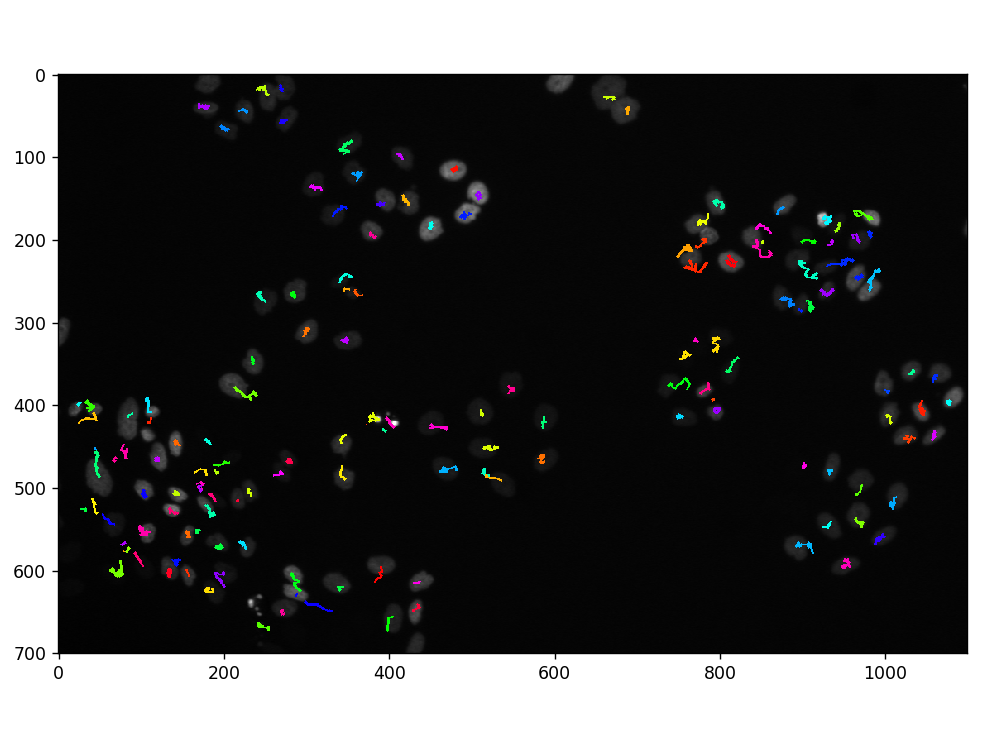

interactive(children=(IntSlider(value=0, description='frame', max=91), Output()), _dom_classes=('widget-intera…

In [78]:
# Adding track renders
util.show_overlay(images,coords,True)